In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import sys
import matplotlib.pyplot as plt

sys.path.append("..")
from src import *

2024-06-07 16:43:18.773127: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 16:43:18.832559: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 16:43:20.321873: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
base = "/data/bionets" if "ramses" in os.uname()[1] else "/data_nfs/"
config_path = "/data/bionets/je30bery/melanoma_data/config.json" if "ramses" in os.uname()[1] else "/data_nfs/je30bery/melanoma_data/config.json"

In [4]:
data = get_data_csv(high_quality_only=False, pfs=True, config_path=config_path)
data = data.reset_index().drop("index", axis=1)

data["Sex"].replace({"m": 1., "f": 0.}, inplace=True)
data["Ulcerated"].replace({True: 1., False: 0.}, inplace=True)
data["Coarse loc"] = data["Localization"].apply(lambda x: coarse_loc(x)).astype(float)
data["Side"] = data["Localization"].apply(lambda x: left_right(x)).astype(float)

In [5]:
def get_features(model, x):
    x = model.res.conv1(x)
    x = model.res.bn1(x)
    x = model.res.relu(x)
    x = model.res.maxpool(x)
    x = model.res.layer1(x)
    x = model.res.layer2(x)
    x = model.res.layer3(x)
    x = model.res.layer4(x)
    x = model.res.avgpool(x)
    return x.detach().cpu().numpy().flatten()

In [6]:

with open(config_path, "r") as f:
    configs = json.load(f)
    dataset_statistics = configs["dataset_statistics"]
    checkpoint_path = configs["model_weights"]
    pretrained_model = configs["pretrained_model_path"]

with open(os.path.join(dataset_statistics, f'melanoma_means.json'), 'r') as fp:
    means = json.load(fp)
    markers = list(means.keys())

In [7]:
model = ResNet18_pretrained(indim=len(markers), checkpoint_path=checkpoint_path)
model.load_state_dict(t.load(pretrained_model, map_location="cpu"))

# model = model.cuda()
model = model.eval()


dl = t.utils.data.DataLoader(MelanomaData(markers, pretrain=True, data=data, mode="val", config_path=config_path), batch_size=1, shuffle=False)
it = iter(dl)
features = list()
labels = list()
while True:
    try:
        x, y = next(it)
        labels.append(y.detach().cpu().numpy()[0])
        features.append(get_features(model, x))
    except StopIteration:
        break
conc = np.concatenate(features)

In [8]:
conc = np.array(features)

In [9]:
conc.shape

(112, 512)

In [10]:
data[list(range(512))] = conc

/tmp/ipykernel_2280220/3037212315.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[list(range(512))] = conc
/tmp/ipykernel_2280220/3037212315.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[list(range(512))] = conc
/tmp/ipykernel_2280220/3037212315.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

In [11]:
data

,Histo-ID,Run-ID,Collection data,Sex,Age,Type,Group,Dataset,Tumor Thickness [mm],Ulcerated,...,502,503,504,505,506,507,508,509,510,511
0,B274,20526,1/18/2017,0.0,43,Superficial Spreading Melanoma,Melanoma,Melanoma,0.20,0.0,...,0.132753,0.148017,0.164551,0.180383,0.194396,0.068863,0.189876,0.036938,0.526476,0.103880
1,B274,20527,1/18/2017,0.0,43,Superficial Spreading Melanoma,Melanoma,Melanoma,0.20,0.0,...,0.025873,0.180971,0.524013,0.076087,0.665300,0.025043,0.039030,0.063941,0.496130,0.051996
2,B274,20528,1/18/2017,0.0,43,Superficial Spreading Melanoma,Melanoma,Melanoma,0.20,0.0,...,0.379834,0.473298,0.363994,0.307070,0.657493,0.326015,0.184313,0.170003,0.238884,0.402774
3,B462,21048,12/11/2018,0.0,78,Superficial Spreading Melanoma,Melanoma,Melanoma,2.25,1.0,...,0.153091,0.265127,0.030781,0.200455,0.018414,0.082627,0.189326,0.436437,0.508319,0.013095
4,B462,21049,12/11/2018,0.0,78,Superficial Spreading Melanoma,Melanoma,Melanoma,2.25,1.0,...,0.383584,0.236963,0.079697,0.451714,0.119891,0.044998,0.852277,0.608540,0.035059,0.151477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,B484,21121,3/25/2019,1.0,52,Superficial Spreading Melanoma,Melanoma,Melanoma,2.60,0.0,...,0.008954,0.443134,0.139646,0.249930,0.253808,0.028288,0.133182,0.868916,0.090797,0.127657
108,B487,21122,3/25/2019,1.0,36,Malignant Melanoma,Melanoma,Melanoma,4.10,0.0,...,0.296876,0.770141,0.364179,0.421228,0.257986,0.209529,0.333003,0.164979,0.114501,0.248121
109,B487,21123,3/25/2019,1.0,36,Malignant Melanoma,Melanoma,Melanoma,4.10,0.0,...,0.525673,0.115636,0.099270,0.541329,0.125984,0.056865,0.578098,0.471864,0.100952,0.130837
110,B502,21130,5/31/2019,0.0,46,Superficial Spreading Melanoma,Melanoma,Melanoma,5.20,1.0,...,0.292115,0.306931,0.025299,0.091940,0.045206,0.114242,0.535107,0.095486,0.902393,0.181255


In [12]:
data, acc, feature_imp = loo_forest(data=data, features=["Sex", "Age", "Tumor Thickness [mm]", "Ulcerated", "Coarse loc", "Side"] + list(range(512)), label="PFS label")

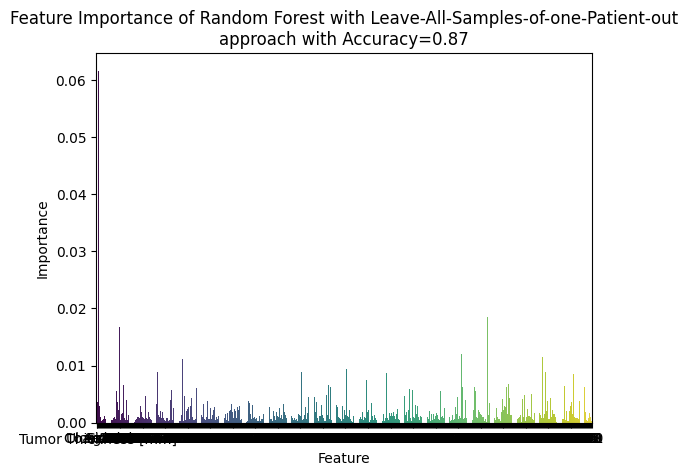

In [13]:
sns.barplot(feature_imp, palette='viridis')
plt.title(f'Feature Importance of Random Forest with Leave-All-Samples-of-one-Patient-out\napproach with Accuracy={acc:.2f}')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

In [14]:
data, acc, feature_imp = loo_forest(data=data, features=["Sex", "Age", "Ulcerated", "Coarse loc", "Side"] + list(range(512)), label="PFS label")

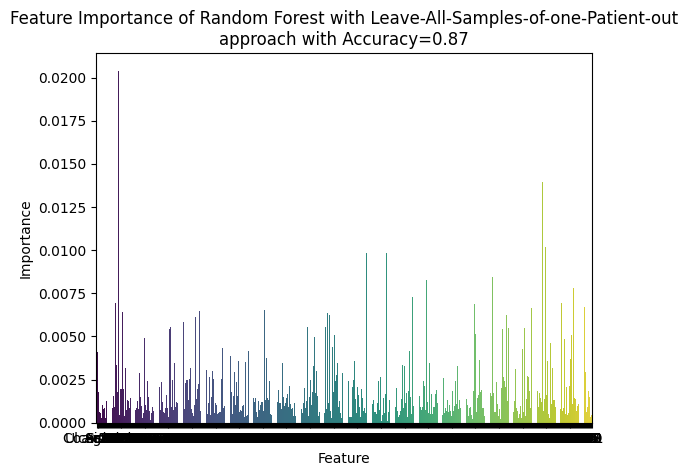

In [15]:
sns.barplot(feature_imp, palette='viridis')
plt.title(f'Feature Importance of Random Forest with Leave-All-Samples-of-one-Patient-out\napproach with Accuracy={acc:.2f}')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

In [16]:
np.argmax(feature_imp)

23

In [17]:
features = ["Sex", "Age", "Ulcerated", "Coarse loc", "Side"] + list(range(512))

In [18]:
features[np.argmax(feature_imp)]

18